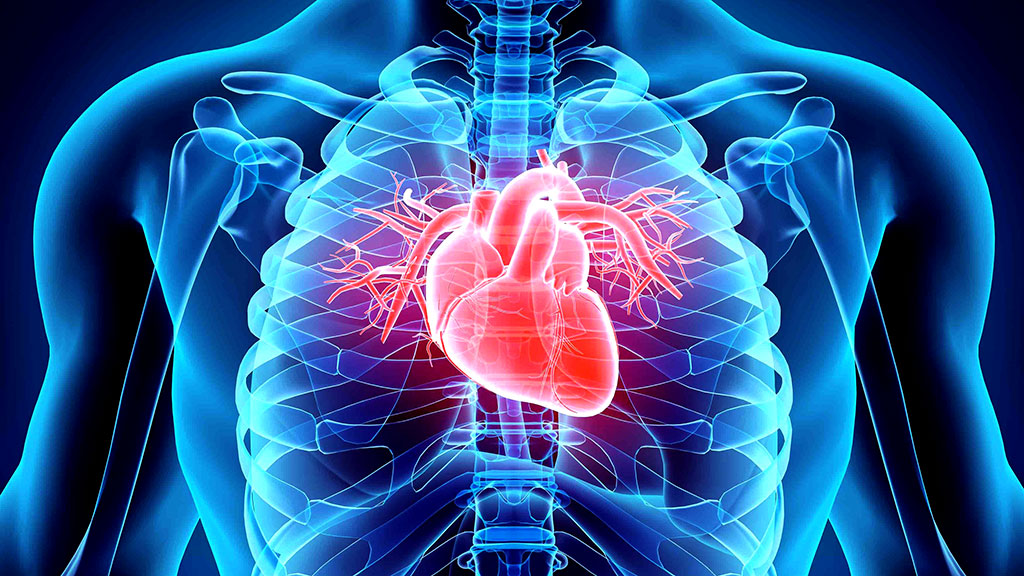

# **Importações e visualização do DataFrame**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC

df = pd.read_csv('heart_cleveland_upload.csv')
df.head()

##**Overview dos dados da tabela**

In [ ]:
df.info()

In [ ]:
df.describe()

##**Verificando a presença de dados nulos**

In [ ]:
df.isnull().sum().sort_values(ascending=False).head()

- Não há valores nulos no DataFrame

##**Separando os dados de Treino/teste**

In [ ]:
from sklearn.model_selection import train_test_split

# Suponha que X são suas features e y o target
X = df.drop('condition', axis=1)
y = df['condition']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Treino:", X_train.shape)
print("Teste:", X_test.shape)

## **Testando Kfold 10**

-Definindo o Random State para 42 (padrão).
- Pipeline para teste > Standard Scaler e uso de validação cruzada com GridSearchCV para encontrar a melhor combinação de hiperparâmetros para o modelo SVM.
- Demonstração da acurácia + matriz de confusão.
- Média e Desvio padrão

              precision    recall  f1-score   support

           0       0.79      0.72      0.75        32
           1       0.71      0.79      0.75        28

    accuracy                           0.75        60
   macro avg       0.75      0.75      0.75        60
weighted avg       0.75      0.75      0.75        60

Acurácia: 0.75
Melhores hiperparâmetros (Heart Desease): {'svm__C': 1, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Melhor score de validação (Heart Desease): 0.8652173913043478
Acurácia teste (Heart Desease, melhor combinação): 0.7333333333333333


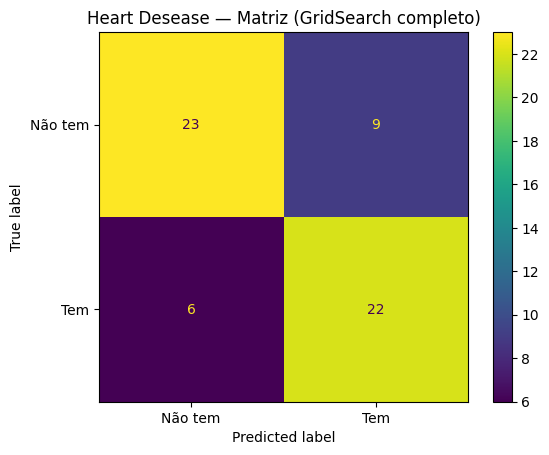

In [12]:
RANDOM_STATE = 42
cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
class_names_heart = ["Não tem", "Tem"]

pipe_linear_i = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", random_state=RANDOM_STATE))
])

pipe_linear_i.fit(X_train, y_train)
ypred_i = pipe_linear_i.predict(X_test)

print(classification_report(y_test, ypred_i))
print("Acurácia:", accuracy_score(y_test, ypred_i))


pipe_full_b = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(random_state=RANDOM_STATE))
])

param_grid_full = {
    "svm__kernel": ["linear", "rbf", "poly", "sigmoid"],
    "svm__C": [0.01, 0.1, 1, 10, 100],
    "svm__gamma": ["scale", 0.01, 0.001 ]
}

grid_full_b = GridSearchCV(pipe_full_b, param_grid_full, cv=cv, n_jobs=-1)
grid_full_b.fit(X_train, y_train)

print("Melhores hiperparâmetros (Heart Desease):", grid_full_b.best_params_)
print("Melhor score de validação (Heart Desease):", grid_full_b.best_score_)

best_model_b = grid_full_b.best_estimator_
print("Acurácia teste (Heart Desease, melhor combinação):", accuracy_score(y_test, best_model_b.predict(X_test)))

ConfusionMatrixDisplay.from_estimator(pipe_linear_i, X_test, y_test, display_labels=class_names_heart)
plt.title("Heart Desease — Matriz (GridSearch completo)")
plt.show()

# **Testando StratiFieldKFold=8**

In [ ]:
RANDOM_STATE = 42
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=RANDOM_STATE)
class_names_heart = ["Não tem", "Tem"]

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(random_state=RANDOM_STATE))
])

param_grid_full = {
    "svm__kernel": ["linear", "rbf", "poly", "sigmoid"],
    "svm__C": [0.01, 0.1, 1, 10, 100],
    "svm__gamma": ["scale", 0.01, 0.001 ] # gamma só é usado para kernels rbf, poly, sigmoid
}

# GridSearchCV com KFold
grid_full_b = GridSearchCV(pipe, param_grid_full, cv=cv, n_jobs=-1)
grid_full_b.fit(X_train, y_train)

print("Melhores hiperparâmetros (Heart Desease):", grid_full_b.best_params_)
print("Melhor score de validação (Heart Desease):", grid_full_b.best_score_)

# --------- LINHAS ADICIONADAS ---------
best_index = grid_full_b.best_index_                                # <<< ADICIONADO
mean_score = grid_full_b.cv_results_["mean_test_score"][best_index] # <<< ADICIONADO
std_score = grid_full_b.cv_results_["std_test_score"][best_index]   # <<< ADICIONADO
print(f"Score médio de validação (cv) do melhor modelo: {mean_score:.2f} ± {std_score:.2f}")  # <<< ADICIONADO
# --------------------------------------

# Avaliação no conjunto de teste
best_model_b = grid_full_b.best_estimator_
y_test_pred = best_model_b.predict(X_test)
print(classification_report(y_test, y_test_pred))
print("Acurácia teste (Heart Desease, melhor combinação):", accuracy_score(y_test, y_test_pred))

# Matriz de confusão do modelo otimizado
ConfusionMatrixDisplay.from_estimator(best_model_b, X_test, y_test, display_labels=class_names_heart)
plt.title("Heart Desease — Matriz (GridSearch com StratifiedKFold-8)")
plt.show()

## **Resultado dos testes KFold=10 e StratiFieldKFold=8**
- Em ambos os modelos, tivemos o mesmo resultado de hiperparâmetros.

## **Usando o KFold=10**

- **Melhores hiperparâmetros** (Heart Desease): {'svm__C': 0.01, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}\
- Melhor score de validação (Heart Desease): 0.8692028985507246\
- Acurácia teste (Heart Desease, melhor combinação): 0.75

## **Usando o StratiFieldKFold=8**

  Melhores hiperparâmetros (Heart Desease): {'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'sigmoid'}\

- Melhor score (Heart Desease): 0.8734195402298851\
- Score médio de validação (cv) do melhor modelo: 0.87 ± 0.05